In [20]:
import os
import time
import joblib
import librosa
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Activation, Input, TimeDistributed, MaxPooling2D, Conv2D, AveragePooling2D, LSTM, BatchNormalization, Reshape, MaxPool1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotnine as p9
import seaborn as sns
import tensorflow.keras.backend as K
from keras.callbacks import ReduceLROnPlateau

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ser-processed/features/spectrogram_padded.pkl
/kaggle/input/ser-processed/features/spectrogram_features.pkl
/kaggle/input/ser-processed/features/aggregated_features.pkl
/kaggle/input/ser-processed/features/mfcc_padded.pkl
/kaggle/input/ser-processed/features/functional_features.pkl
/kaggle/input/ser-processed/features/mfcc_features.pkl


In [3]:
spectrogram_features = joblib.load('/kaggle/input/ser-processed/features/spectrogram_features.pkl')
mfcc_features = joblib.load('/kaggle/input/ser-processed/features/mfcc_features.pkl')
functional_features = joblib.load('/kaggle/input/ser-processed/features/functional_features.pkl')
aggregated_features = joblib.load('/kaggle/input/ser-processed/features/aggregated_features.pkl')

In [77]:

Y = functional_features['Emotion']
X = spectrogram_features

def preprocess_data(X, Y):
    df = pd.DataFrame([x.shape for x in X])
    dim2max = df[1].max()
    X = [np.pad(x, ((0, 0), (0, dim2max - x.shape[1])), mode='constant', constant_values=0) for x in X]
    X = [x[:, :128] for x in X]
    Y_names = np.unique(Y)
    Y = LabelEncoder().fit(Y).transform(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = to_categorical(Y_train, num_classes=np.unique(Y).size)
    Y_test = to_categorical(Y_test, num_classes=np.unique(Y).size)

    print(X_train[10].shape, X_test[10].shape)
    return X_train, X_test, Y_train, Y_test, Y_names

X_train, X_test, Y_train, Y_test, Y_names = preprocess_data(X, Y)

(128, 128) (128, 128)


In [78]:
Y_names

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [5]:
def plot_results(model, history, X_test, Y_test, Y_names):
    y_pred  = model.predict(X_test)
    y_pred  = np.argmax(y_pred, axis=1)
    y_check = np.argmax(Y_test,axis=1)
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    conf = confusion_matrix(y_check, y_pred)
    cm = pd.DataFrame(
        conf, index=[i for i in Y_names],
        columns=[i for i in Y_names]
    )

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 1 row and 2 columns

    # Plot on first axis
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot on second axis
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.loglog()
    ax2.legend(loc='lower right')

    ax3 = sns.heatmap(cm,annot=True,fmt='d')
    ax3.set_title(f'confusion matrix for model ')

    # Optional: Adjust spacing between plots (optional)
    plt.tight_layout()

    plt.show()

    print(f'Model Confusion Matrix\n', classification_report(y_check, y_pred, target_names=Y_names))

# Baseline model

In [44]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001)

def Simple_CNN_small(out=7) :
    model = Sequential()
    model.add(Conv1D(32, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(out))
    model.add(Activation('softmax'))
    print(model.summary())
    return model




def weighted_cross_entropy(y_true, y_pred, weights):
    # Clip predictions to prevent log(0) and log(1) errors.
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    
    # Calculate weighted cross entropy
    weighted_losses = y_true * K.log(y_pred) * weights + (1.0 - y_true) * K.log(1.0 - y_pred)
    loss = -K.mean(weighted_losses, axis=-1)
    
    return loss


unique_elements, counts = np.unique(Y, return_counts=True)

weights = (1/counts)/np.sum(1/counts)

In [45]:
np.random.seed(32)
tf.random.set_seed(32)

Simple_CNN_small_1 = Simple_CNN_small()
Simple_CNN_small_1.compile(optimizer=SGD(learning_rate=0.05, momentum=0.8),  loss=lambda y_true, y_pred: weighted_cross_entropy(y_true, y_pred, weights), metrics=['accuracy'])
Simple_CNN_small_history_1 = Simple_CNN_small_1.fit(X_train, Y_train, batch_size=64, epochs=300, validation_data=(X_test, Y_test), callbacks=[callback, reduce_lr])

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 128, 32)        │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │        28,679 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,191 (192.15 KB)

 Trainable params: 49,191 (192.15 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
 46/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1282 - loss: 0.8395

W0000 00:00:1714909144.501278     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1516 - loss: 0.7413

W0000 00:00:1714909148.476855     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1516 - loss: 0.7409 - val_accuracy: 0.1934 - val_loss: 0.3094 - learning_rate: 0.0500
Epoch 2/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2039 - loss: 0.2809 - val_accuracy: 0.2166 - val_loss: 0.1912 - learning_rate: 0.0500
Epoch 3/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2244 - loss: 0.2135 - val_accuracy: 0.3004 - val_loss: 0.2069 - learning_rate: 0.0500
Epoch 4/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3044 - loss: 0.1873 - val_accuracy: 0.3306 - val_loss: 0.1591 - learning_rate: 0.0500
Epoch 5/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3251 - loss: 0.1640 - val_accuracy: 0.3468 - val_loss: 0.1537 - learning_rate: 0.0500
Epoch 6/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3261 - loss: 0.1586 - val_accuracy: 0.3525 - val_loss: 0.1522 - learning_rate: 0.0500
Epoch 7/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3398 - loss: 0.1543 - val_

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Loss: 0.14697396755218506
Test Accuracy: 0.39210206270217896


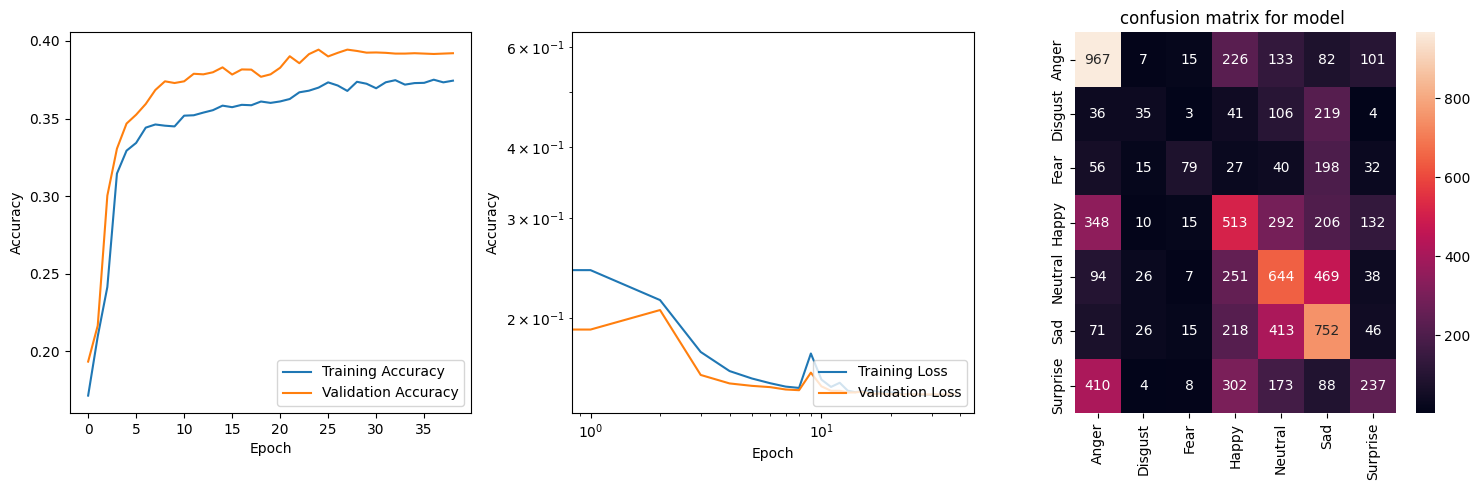

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.49      0.63      0.55      1531
     Disgust       0.28      0.08      0.12       444
        Fear       0.56      0.18      0.27       447
       Happy       0.33      0.34      0.33      1516
     Neutral       0.36      0.42      0.39      1529
         Sad       0.37      0.49      0.42      1541
    Surprise       0.40      0.19      0.26      1222

    accuracy                           0.39      8230
   macro avg       0.40      0.33      0.34      8230
weighted avg       0.39      0.39      0.37      8230



In [46]:
plot_results(Simple_CNN_small_1, Simple_CNN_small_history_1, X_test, Y_test, Y_names)

# Lats try separating emotions into positive negatie and neutrral groups and check if training such model first and then a model which will discriminate between positive emotion is better?

(128, 128) (128, 128)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,699 (6.00 MB)

 Trainable params: 1,573,699 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3974 - loss: 0.5243 - val_accuracy: 0.3734 - val_loss: 0.3907 - learning_rate: 0.0100
Epoch 2/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3858 - loss: 0.3904 - val_accuracy: 0.3773 - val_loss: 0.3906 - learning_rate: 0.0100
Epoch 3/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3909 - loss: 0.3907 - val_accuracy: 0.3880 - val_loss: 0.3905 - learning_rate: 0.0100
Epoch 4/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3912 - loss: 0.3900 - val_accuracy: 0.3741 - val_loss: 0.3907 - learning_rate: 0.0100
Epoch 5/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3879 - loss: 0.3900 - val_accuracy: 0.4139 - val_loss: 0.3994 - learning_rate: 0.0100
Epoch 6/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3922 - loss: 0.3907 - val_accuracy: 0.3746 - val_loss: 0.3907 - learning_rate: 0.0100
Epoch 7/300
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.38

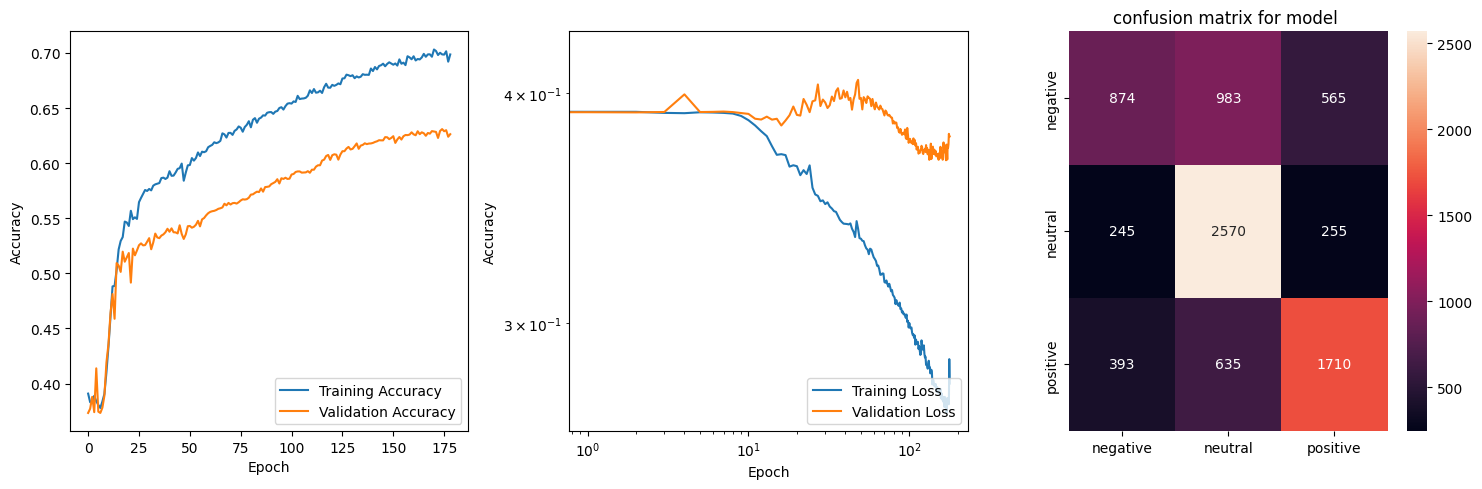

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.58      0.36      0.44      2422
     neutral       0.61      0.84      0.71      3070
    positive       0.68      0.62      0.65      2738

    accuracy                           0.63      8230
   macro avg       0.62      0.61      0.60      8230
weighted avg       0.62      0.63      0.61      8230



In [86]:
np.random.seed(32)
tf.random.set_seed(32)

callback = keras.callbacks.EarlyStopping(monitor='loss',patience=8)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001)

X_train, X_test, Y_train, Y_test, Y_names = preprocess_data(X, ["positive" if a in [ "Happy", "Surprise"] else ("neutral" if a in ["Sad", "Neutral"] else "negative") for a in functional_features['Emotion']])

unique_elements, counts = np.unique(np.sum(Y_train * [1,2,3], axis=1), return_counts=True)
weights = (1/counts)/np.sum(1/counts)

two_class = Sequential()
two_class.add(Conv2D(32, 5, padding='same', input_shape=(128, 128, 1)))

two_class.add(Activation('relu'))
two_class.add(Dropout(0.4))
two_class.add(Flatten())
two_class.add(Dense(len(unique_elements)))
two_class.add(Activation('softmax'))
print(two_class.summary())


two_class.compile(optimizer=SGD(learning_rate=0.01, momentum=0.8),  loss=lambda y_true, y_pred: weighted_cross_entropy(y_true, y_pred, weights), metrics=['accuracy'])
two_class_history = two_class.fit(X_train, Y_train, batch_size=64, epochs=300, validation_data=(X_test, Y_test), callbacks=[callback, reduce_lr])

plot_results(two_class, two_class_history, X_test, Y_test, Y_names)


Not good enough. Let's ttry different network architectures

(128, 128) (128, 128)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 16)   │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │       786,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,515 (3.00 MB)

 Trainable params: 786,515 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Loss: 0.25479573011398315
Test Accuracy: 0.723450779914856


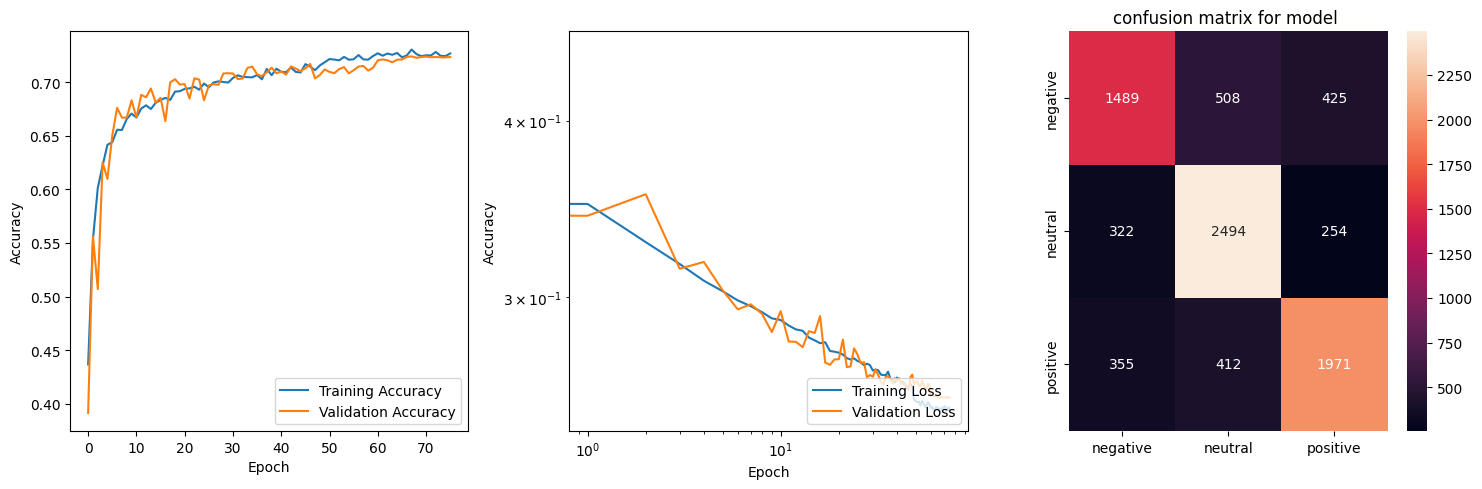

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.69      0.61      0.65      2422
     neutral       0.73      0.81      0.77      3070
    positive       0.74      0.72      0.73      2738

    accuracy                           0.72      8230
   macro avg       0.72      0.72      0.72      8230
weighted avg       0.72      0.72      0.72      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 16)   │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 16)   │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │       786,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,555 (3.00 MB)

 Trainable params: 787,555 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Loss: 0.2961267828941345
Test Accuracy: 0.6640340089797974


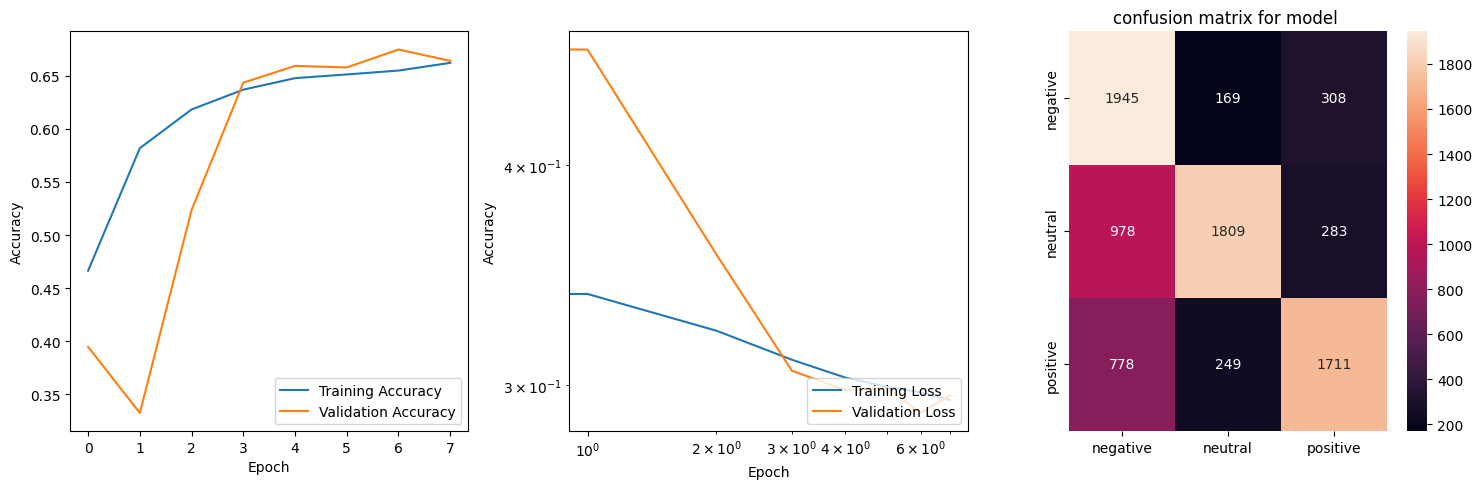

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.53      0.80      0.64      2422
     neutral       0.81      0.59      0.68      3070
    positive       0.74      0.62      0.68      2738

    accuracy                           0.66      8230
   macro avg       0.69      0.67      0.67      8230
weighted avg       0.70      0.66      0.67      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │       786,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,851 (3.00 MB)

 Trainable params: 786,851 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Loss: 0.3055180013179779
Test Accuracy: 0.6486026644706726


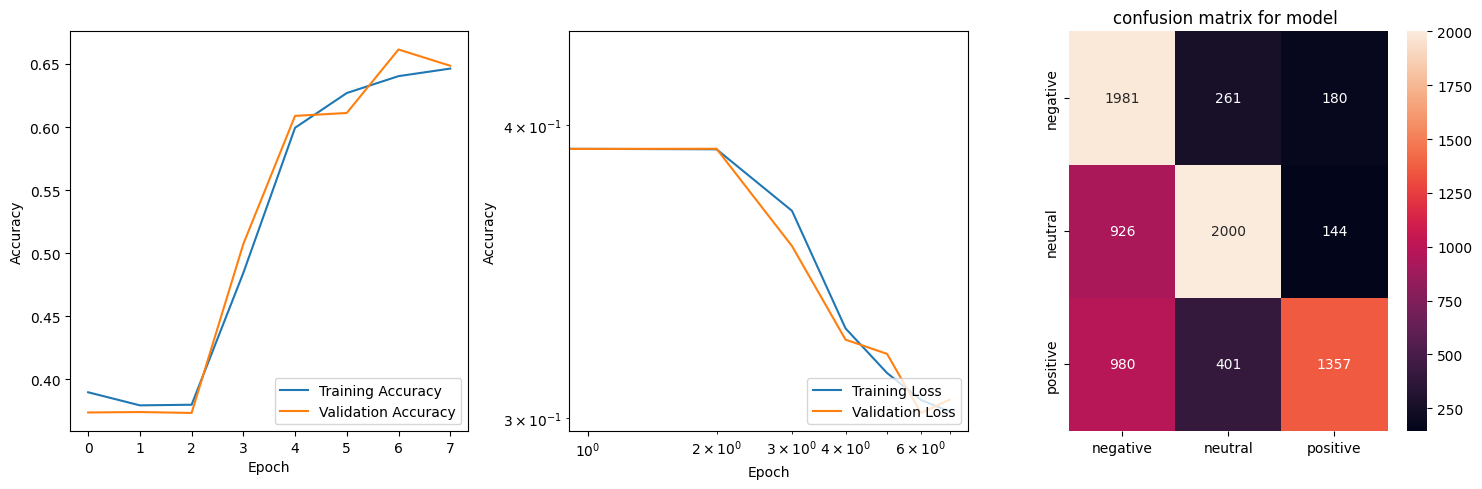

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.51      0.82      0.63      2422
     neutral       0.75      0.65      0.70      3070
    positive       0.81      0.50      0.61      2738

    accuracy                           0.65      8230
   macro avg       0.69      0.66      0.65      8230
weighted avg       0.70      0.65      0.65      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │       786,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,267 (3.03 MB)

 Trainable params: 793,267 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Test Loss: 0.3363301753997803
Test Accuracy: 0.5710813999176025


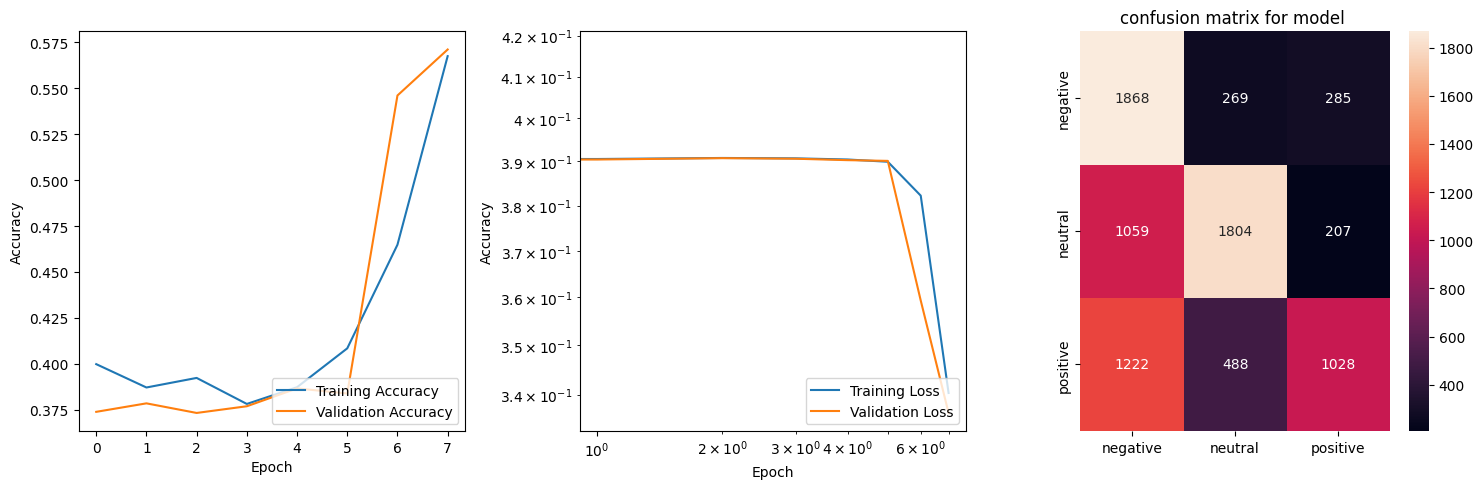

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.45      0.77      0.57      2422
     neutral       0.70      0.59      0.64      3070
    positive       0.68      0.38      0.48      2738

    accuracy                           0.57      8230
   macro avg       0.61      0.58      0.56      8230
weighted avg       0.62      0.57      0.57      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 16)   │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │       786,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,235 (3.00 MB)

 Trainable params: 787,235 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Loss: 0.3905864953994751
Test Accuracy: 0.37946537137031555


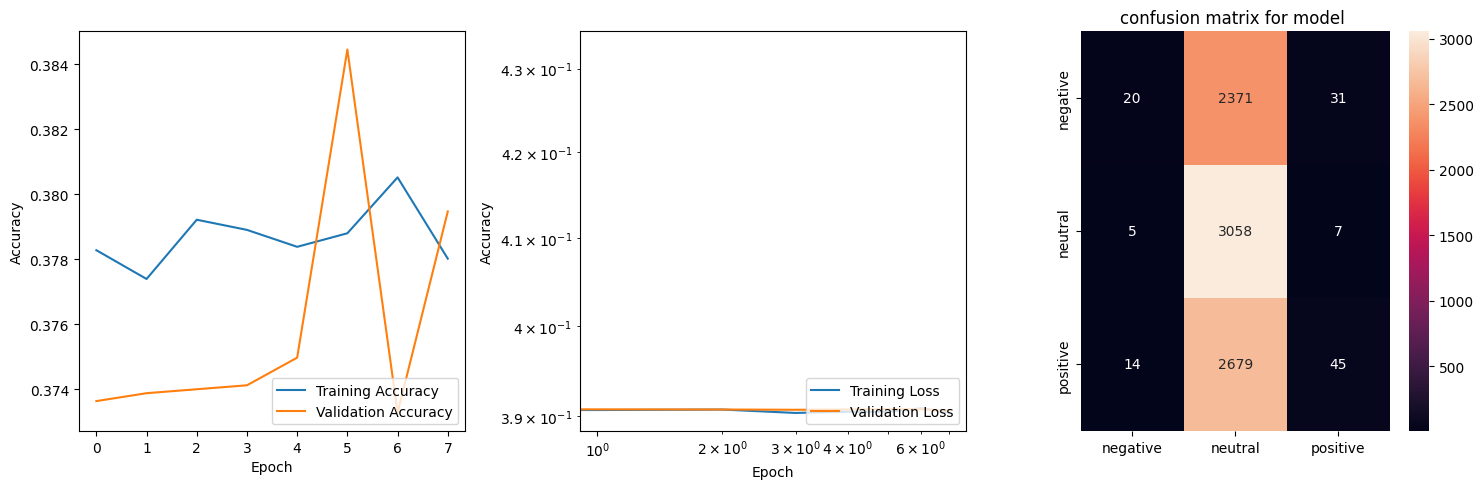

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.51      0.01      0.02      2422
     neutral       0.38      1.00      0.55      3070
    positive       0.54      0.02      0.03      2738

    accuracy                           0.38      8230
   macro avg       0.48      0.34      0.20      8230
weighted avg       0.47      0.38      0.22      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 16)   │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 16)   │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │       786,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 799,795 (3.05 MB)

 Trainable params: 799,795 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Test Loss: 0.390587717294693
Test Accuracy: 0.37837180495262146


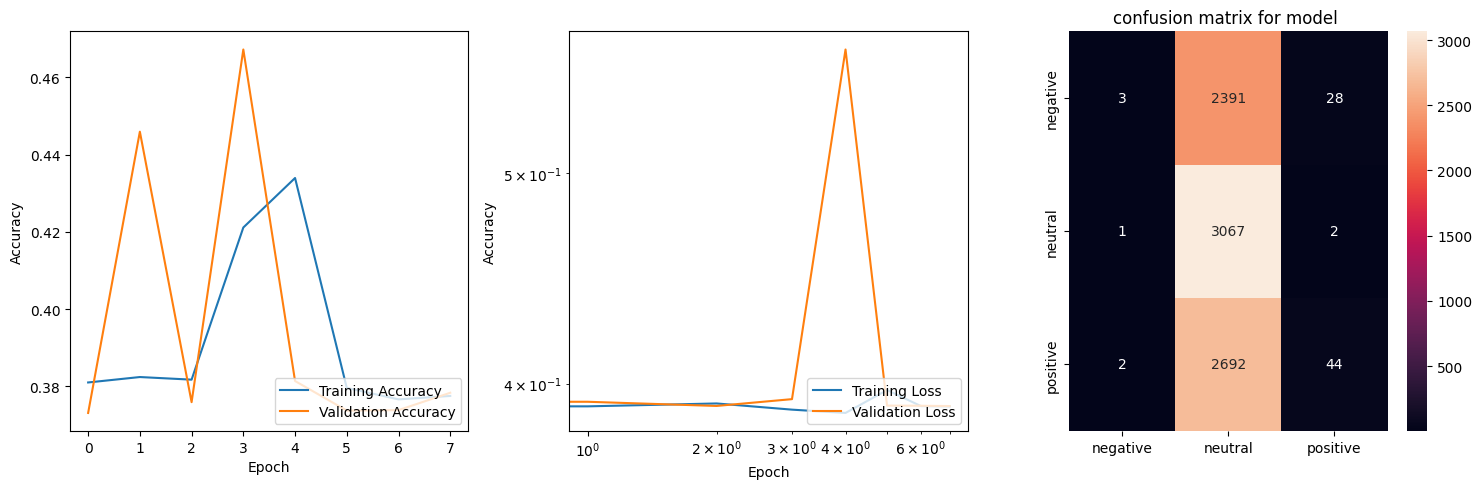

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.50      0.00      0.00      2422
     neutral       0.38      1.00      0.55      3070
    positive       0.59      0.02      0.03      2738

    accuracy                           0.38      8230
   macro avg       0.49      0.34      0.19      8230
weighted avg       0.49      0.38      0.22      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,027 (6.00 MB)

 Trainable params: 1,573,027 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Loss: 0.3907710015773773
Test Accuracy: 0.373025506734848


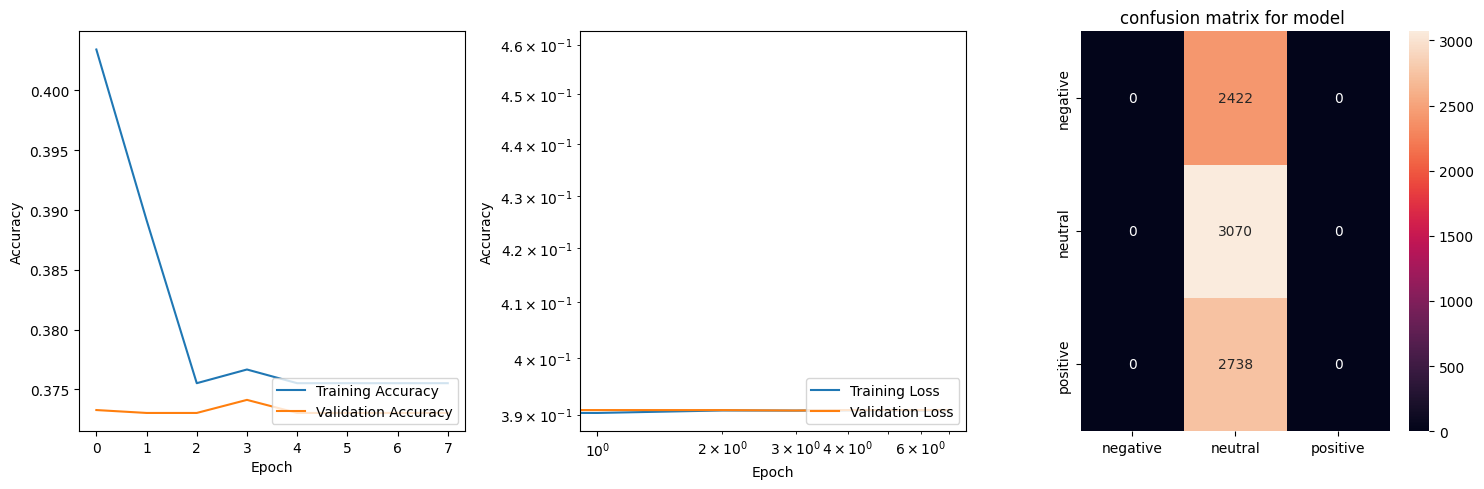

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2422
     neutral       0.37      1.00      0.54      3070
    positive       0.00      0.00      0.00      2738

    accuracy                           0.37      8230
   macro avg       0.12      0.33      0.18      8230
weighted avg       0.14      0.37      0.20      8230



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` objec

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 32)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_78 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,155 (6.02 MB)

 Trainable params: 1,577,155 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Test Loss: 0.29057812690734863
Test Accuracy: 0.6664641499519348


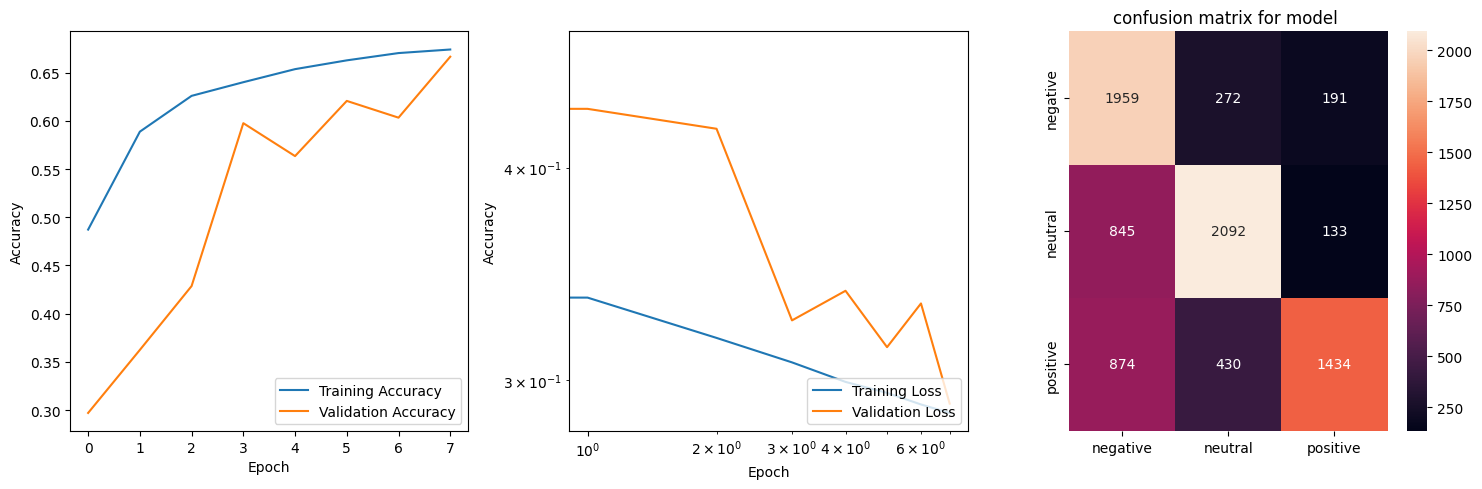

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.53      0.81      0.64      2422
     neutral       0.75      0.68      0.71      3070
    positive       0.82      0.52      0.64      2738

    accuracy                           0.67      8230
   macro avg       0.70      0.67      0.66      8230
weighted avg       0.71      0.67      0.67      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_79 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_80 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,699 (6.00 MB)

 Trainable params: 1,573,699 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Loss: 0.2839988172054291
Test Accuracy: 0.684447169303894


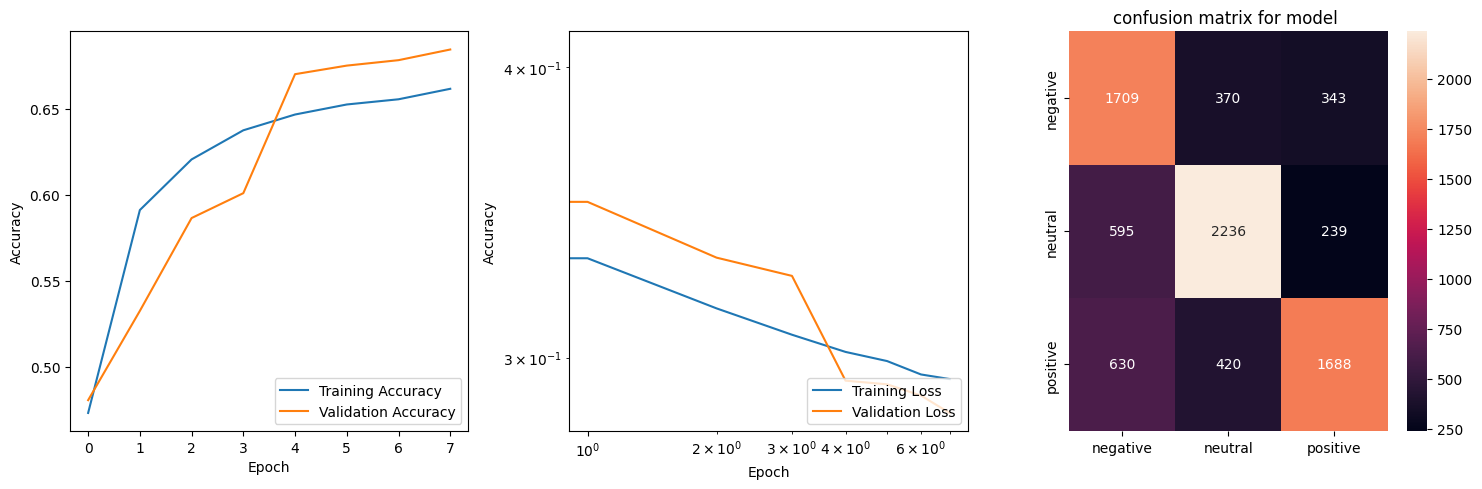

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.58      0.71      0.64      2422
     neutral       0.74      0.73      0.73      3070
    positive       0.74      0.62      0.67      2738

    accuracy                           0.68      8230
   macro avg       0.69      0.68      0.68      8230
weighted avg       0.69      0.68      0.69      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_81 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_82 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,599,331 (6.10 MB)

 Trainable params: 1,599,331 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Test Loss: 0.3907529413700104
Test Accuracy: 0.37533414363861084


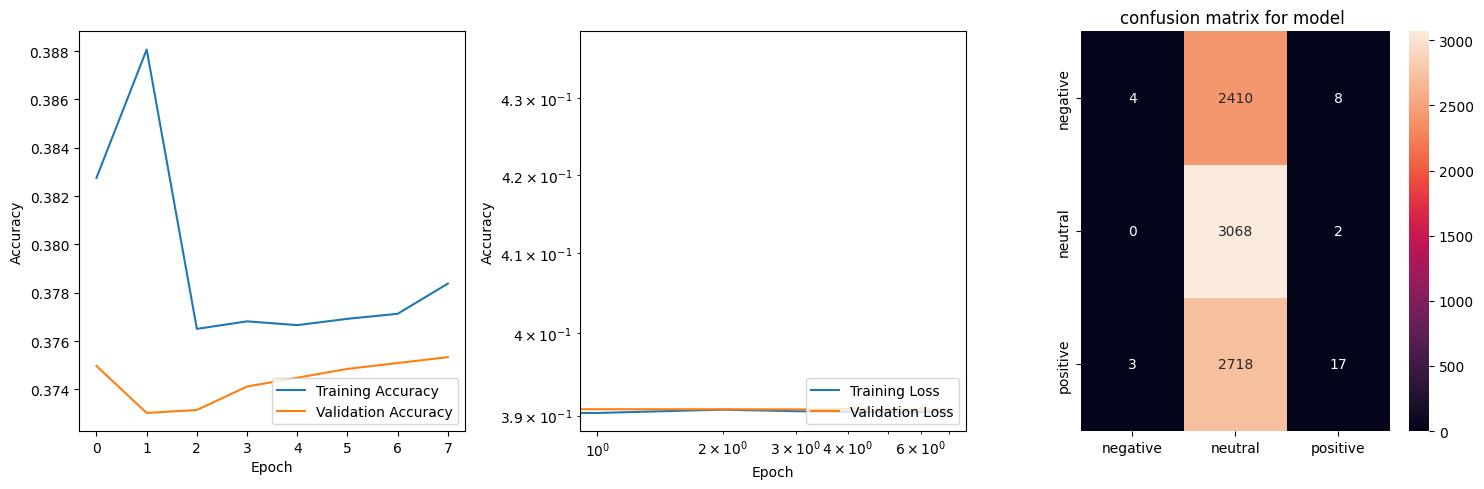

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.57      0.00      0.00      2422
     neutral       0.37      1.00      0.54      3070
    positive       0.63      0.01      0.01      2738

    accuracy                           0.38      8230
   macro avg       0.53      0.34      0.19      8230
weighted avg       0.52      0.38      0.21      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_83 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_84 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,467 (6.01 MB)

 Trainable params: 1,574,467 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Loss: 0.28845497965812683
Test Accuracy: 0.6676792502403259


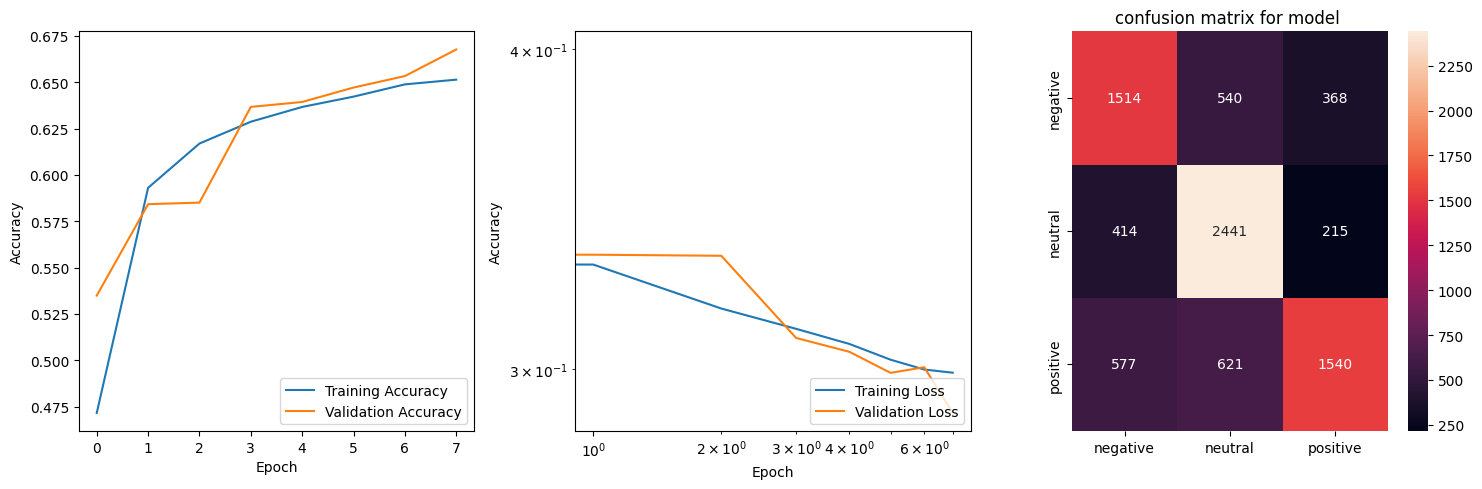

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.60      0.63      0.61      2422
     neutral       0.68      0.80      0.73      3070
    positive       0.73      0.56      0.63      2738

    accuracy                           0.67      8230
   macro avg       0.67      0.66      0.66      8230
weighted avg       0.67      0.67      0.66      8230



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 128, 128, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_85 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 3)              │     1,572,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_86 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,675 (6.20 MB)

 Trainable params: 1,624,675 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

None
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
Test Loss: 0.4266171157360077
Test Accuracy: 0.4599027931690216


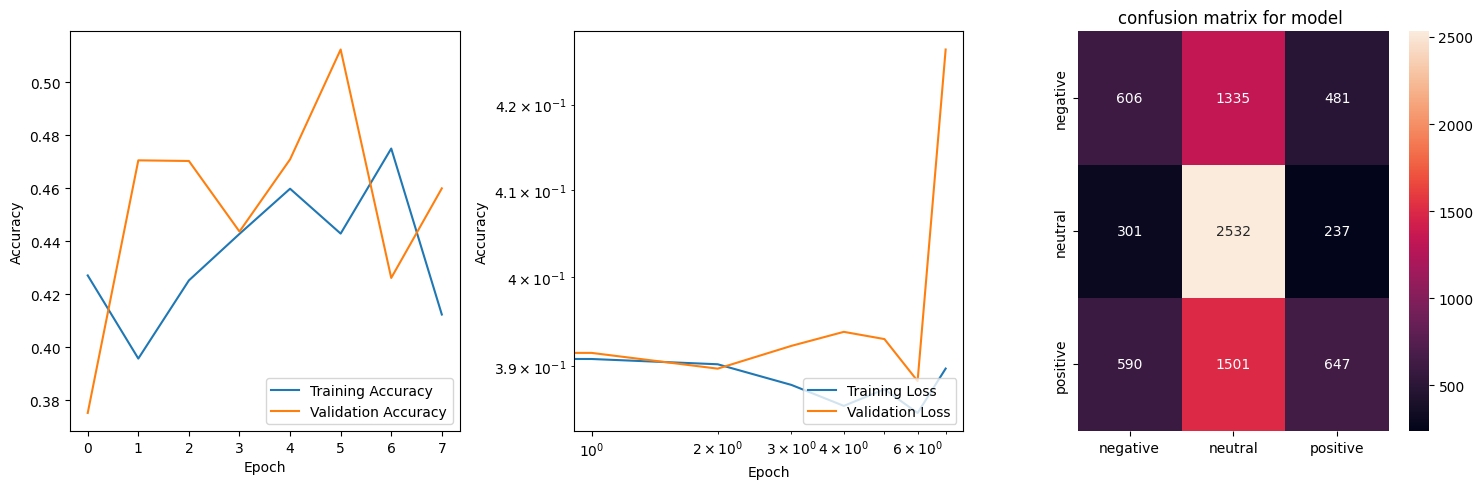

Model Confusion Matrix
               precision    recall  f1-score   support

    negative       0.40      0.25      0.31      2422
     neutral       0.47      0.82      0.60      3070
    positive       0.47      0.24      0.32      2738

    accuracy                           0.46      8230
   macro avg       0.45      0.44      0.41      8230
weighted avg       0.45      0.46      0.42      8230



In [93]:
np.random.seed(32)
tf.random.set_seed(32)

callback = keras.callbacks.EarlyStopping(monitor='loss',patience=8)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001)

X_train, X_test, Y_train, Y_test, Y_names = preprocess_data(X, ["positive" if a in [ "Happy", "Surprise"] else ("neutral" if a in ["Sad", "Neutral"] else "negative") for a in functional_features['Emotion']])

unique_elements, counts = np.unique(np.sum(Y_train * [1,2,3], axis=1), return_counts=True)
weights = (1/counts)/np.sum(1/counts)

for conv_size in [16, 32]:
    for height in [2, 5, 7]:
        for layers in [1,2]:
            model = Sequential()
            for _ in range(layers):
                model.add(Conv2D(conv_size, height, padding='same', input_shape=(128, 128, 1)))

            model.add(Activation('relu'))
            model.add(Dropout(0.4))
            model.add(Flatten())
            model.add(Dense(len(unique_elements)))
            model.add(Activation('softmax'))

            
            print(model.summary())
            model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.8),  loss=lambda y_true, y_pred: weighted_cross_entropy(y_true, y_pred, weights), metrics=['accuracy'])
            model_history = model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test), callbacks=[callback, reduce_lr], verbose=0)

            plot_results(model, model_history, X_test, Y_test, Y_names)



# Moving on to statistical models

array([0.37354774, 0.29299487, 0.33345739])